In [93]:
# Recommendation: `conda install --channel conda-forge geopandas`
import numpy as np
import math
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import entropy
import shapely
import json
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from tqdm import tqdm
import os

import scorers
import redistricting
import matplotlib.ticker as ticker

In [94]:
def splits_to_regions_binary(row, splits):
    if splits is None:
        return 0
    if len(splits) == 0:
        return 0

    num = 0
    for v in splits:
        num = 2 * num + row[v]
    return num


def count_disjoints(geometry):
    if type(geometry) == Polygon:
        return 1
    else:
        return len(geometry.geoms)

In [95]:
voting_precincts = gpd.read_file("data_prep/output/md_2020")
voting_precincts = voting_precincts.to_crs("EPSG:4326")
n_districts = 4  # row["districts"]
pop = "POP20"  # row["population"]
d_votes = "G20PREDBID"  # "USH16D" #row["dem_votes"]
r_votes = "G20PRERTRU"  # row["rep_votes"]
voting_precincts.sample(n=1)
voting_precincts["POP20"] = voting_precincts["POP20"].fillna(0)

<Axes: >

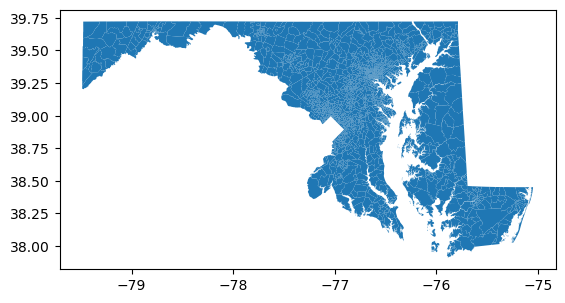

In [96]:
voting_precincts.plot()

In [97]:
voting_precincts[
    "REPRESENTATIVE_POINT"
] = (
    voting_precincts.centroid
)  # voting_precincts.representative_point() https://gis.stackexchange.com/a/414263
voting_precincts["RP_LON"] = voting_precincts["REPRESENTATIVE_POINT"].apply(
    lambda p: p.x
)
voting_precincts["RP_LAT"] = voting_precincts["REPRESENTATIVE_POINT"].apply(
    lambda p: p.y
)

C:\Users\yagne\AppData\Local\Temp\ipykernel_2580\3698497634.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  voting_precincts['REPRESENTATIVE_POINT'] =  voting_precincts.centroid # voting_precincts.representative_point() https://gis.stackexchange.com/a/414263


<Axes: >

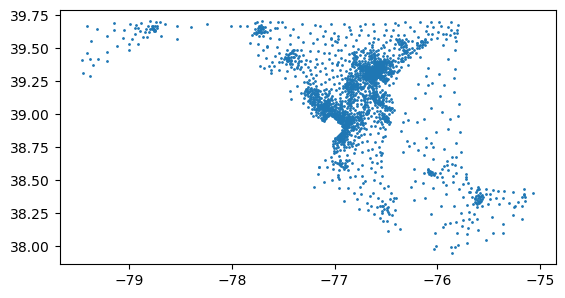

In [98]:
voting_precincts.REPRESENTATIVE_POINT.plot(markersize=1)

In [99]:
orig_voting = voting_precincts[[d_votes, r_votes]].sum() / (
    voting_precincts[[d_votes, r_votes]].sum().sum()
)
orig_voting

G20PREDBID    0.67029
G20PRERTRU    0.32971
dtype: float64

In [100]:
df = voting_precincts
n_districts = 4
holder = []
n_split = 1
pop_col = "POP20"
dem_col = "G20PREDBID"
rep_col = "G20PRERTRU"
orig_dem = orig_voting[dem_col]
orig_rep = orig_voting[rep_col]
score_fn = scorers.equalize_voting
n_sample_angles = None
degree_limit = 0
dissolve_check = False  #

In [114]:
## First Iteration
if n_districts % 2 == 0:
    part_a = n_districts / 2
    part_b = n_districts / 2
else:
    part_a = math.ceil(n_districts / 2)
    part_b = math.floor(n_districts / 2)
pop_total = df[pop_col].sum()
print(pop_total)

# Get Population Center
pop_center_LON = (df["RP_LON"] * df[pop_col]).sum() / pop_total
pop_center_LAT = (df["RP_LAT"] * df[pop_col]).sum() / pop_total
print(pop_center_LON, pop_center_LAT)

# Re-center LAT/LON relative to the Population Center
df["RECENTERED_LON"] = df["RP_LON"] - pop_center_LON
df["RECENTERED_LAT"] = df["RP_LAT"] - pop_center_LAT


df["RECENTERED_ANGLE"] = np.degrees(
    np.arctan2(df["RECENTERED_LAT"], df["RECENTERED_LON"])
)
df["RECENTERED_ANGLE"] = df["RECENTERED_ANGLE"].apply(lambda x: x if x > 0 else x + 360)

n_sample_angles = 1
## LOOP for d in 0 to 359 ##
start_angles = np.linspace(0, 359, 360)
if n_sample_angles:
    start_angles = np.random.choice(start_angles, size=n_sample_angles)
# Set Tracker for Angle Ranges and Competitiveness
angle_ranges = []

for d in start_angles:
    # Reset Angle to be Relative to d
    df["RESETTED_ANGLE"] = df["RECENTERED_ANGLE"] - d
    df["RESETTED_ANGLE"] = df["RESETTED_ANGLE"].apply(
        lambda x: x if x > 0 else (x + 360)
    )
    df = df.sort_values("RESETTED_ANGLE").reset_index(drop=True)

    # Spin Clock Around till you achieve the desired ratio
    i = 0
    captured_pop = 0
    pop_threshold = (part_a) / (part_a + part_b) * pop_total
    while captured_pop < pop_threshold:
        captured_pop += df.loc[i, pop_col]
        i += 1
    final_angle = df.loc[i - 1, "RECENTERED_ANGLE"]

    ## Check if angle range loops past 360 for conditions:
    a1, a2 = d, final_angle

    # If specified, skip past any second hand angle that is not far away from the first handle angle.
    if abs(a2 - a1) <= degree_limit:
        continue

    ## Checking if swapping the last district will get us closer to the desired proportion.
    if a1 < a2:
        pop_check1 = df.loc[
            (a1 <= df["RECENTERED_ANGLE"]) & (df["RECENTERED_ANGLE"] <= a2)
        ][
            pop_col
        ].sum()  # right inclusive
        pop_check2 = df.loc[
            (a1 <= df["RECENTERED_ANGLE"]) & (df["RECENTERED_ANGLE"] < a2)
        ][
            pop_col
        ].sum()  # right exclusive
    else:
        pop_check1 = df.loc[
            (df["RECENTERED_ANGLE"] >= a1) | (df["RECENTERED_ANGLE"] <= a2)
        ][
            pop_col
        ].sum()  # right inclusive
        pop_check2 = df.loc[
            (df["RECENTERED_ANGLE"] >= a1) | (df["RECENTERED_ANGLE"] < a2)
        ][
            pop_col
        ].sum()  # right exclusive

    balance_1 = (pop_check1 / pop_total) * (1 - (pop_check1 / pop_total))
    balance_2 = (pop_check2 / pop_total) * (1 - (pop_check2 / pop_total))
    balance_desired = (part_a) / (part_a + part_b) * (1 - (part_a) / (part_a + part_b))

    inclusive = (
        True
        if abs(balance_1 - balance_desired) <= abs(balance_2 - balance_desired)
        else False
    )

    if a1 < a2:
        if inclusive:
            df[f"SPLIT_{n_split}"] = df["RECENTERED_ANGLE"].apply(
                lambda x: 1 if a1 <= x <= a2 else 0
            )
        else:
            df[f"SPLIT_{n_split}"] = df["RECENTERED_ANGLE"].apply(
                lambda x: 1 if a1 <= x < a2 else 0
            )
    elif a1 > a2:
        if inclusive:
            df[f"SPLIT_{n_split}"] = df["RECENTERED_ANGLE"].apply(
                lambda x: 1 if ((x >= a1) or (x <= a2)) else 0
            )
        else:
            df[f"SPLIT_{n_split}"] = df["RECENTERED_ANGLE"].apply(
                lambda x: 1 if ((x >= a1) or (x < a2)) else 0
            )

    # Dissolve Check for Non-Contiguity
    if dissolve_check:
        dissolved_df = df.dissolve(by=f"SPLIT_{n_split}")
        dissolved_df["disjoints"] = dissolved_df["geometry"].apply(
            lambda x: count_disjoints(x)
        )
        dissolved_pieces = dissolved_df["disjoints"].sum()
    else:
        dissolved_pieces = 0

    df_a = df.loc[df[f"SPLIT_{n_split}"] == 1].copy().reset_index(drop=True)
    df_b = df.loc[df[f"SPLIT_{n_split}"] == 0].copy().reset_index(drop=True)

    # Metric Calculation, Change to any function chosen.
    score = score_fn(df_a, df_b, dem_col, rep_col, orig_dem=orig_dem, orig_rep=orig_rep)
    angle_ranges.append(
        {
            "start": d,
            "end": final_angle,
            "score": score,
            "disjoints": dissolved_pieces,
            "pop_1": (pop_check1, balance_1),
            "pop_2": (pop_check2, balance_2),
            "inclusive": inclusive,
        }
    )

6177189.0
-76.80288410163959 39.136394891354676


In [115]:
captured_pop

3092871.0

In [116]:
angle_ranges

[{'start': 34.0,
  'end': 199.35173409171622,
  'score': 0.02554128211339901,
  'disjoints': 0,
  'pop_1': (3092871.0, 0.24999952071352485),
  'pop_2': (3087988.0, 0.2499999903599379),
  'inclusive': False}]

In [117]:
df.loc[(df["RECENTERED_ANGLE"] >= a1) | (df["RECENTERED_ANGLE"] < a2)][pop_col].sum()

6177189.0

In [118]:
df.loc[(a1 <= df["RECENTERED_ANGLE"]) & (df["RECENTERED_ANGLE"] <= a2)][pop_col].sum()

3092871.0

In [107]:
d, final_angle

(252.0, 62.56448299353363)

In [108]:
captured_pop

3090541.0

In [109]:
df.sample(n=1)

,NAME,NUMBER,JURSCODE,VOTESPRE,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREGHAW,G20PREBSEG,G20PREOWRI,...,POP20,geometry,REPRESENTATIVE_POINT,RP_LON,RP_LAT,RECENTERED_LON,RECENTERED_LAT,RECENTERED_ANGLE,RESETTED_ANGLE,SPLIT_1
2017,PRINCE GEORGE'S PRECINCT 09-012,09-012,PRIN,009-012,126,11,0,0,2,1,...,359.0,"POLYGON ((-76.92693 38.78991, -76.92695 38.789...",POINT (-76.93164 38.78937),-76.931636,38.78937,-0.128752,-0.347024,249.64434,357.64434,0


In [110]:
angle_ranges

[{'start': 252.0,
  'end': 62.56448299353363,
  'score': 0.08916193303941378,
  'disjoints': 0,
  'pop_1': (3090541.0, 0.24999990070507838),
  'pop_2': (3087927.0, 0.24999998832328285),
  'inclusive': False}]

<Axes: >

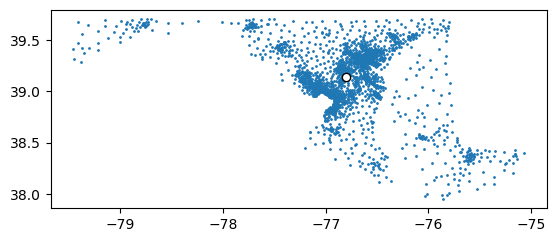

In [111]:
fig, ax = plt.subplots(1, 1)

points = []
# for x in range(2**split):
#     sub = input_df.loc[input_df['TEMP_DISTRICT'] == x]
#     if sub.shape[0] == 0:
#         continue
#     pop_center_LON = (sub['RP_LON'] * sub[pop]).sum()/sub[pop].sum()
# pop_center_LAT =  (sub['RP_LAT'] * sub[pop]).sum()/sub[pop].sum()

df_points = gpd.GeoDataFrame(geometry=df["REPRESENTATIVE_POINT"])
base = df_points.plot(ax=ax, markersize=1)
point = shapely.geometry.Point(pop_center_LON, pop_center_LAT)
points.append(point)
pop_center_df = gpd.GeoDataFrame(geometry=points)
pop_center_df.plot(ax=ax, color="white", linewidth=1.0, edgecolor="black")